In [133]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [134]:
import pandas as pd
file_path = "adult.data"
df = pd.read_csv(file_path, header=None)
df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [135]:
# Build a list of column names based on the information in the link
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "salary"
]

# Assign column names to the DataFrame
df.columns = column_names


In [136]:
# Check the shape of the DataFrame
print(df.shape)
# Drop the 3rd column from the DataFrame
df.drop(columns=['fnlwgt'], inplace=True)
# Replace values in the "salary" column
df['salary'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
# Create X dataframe (predictors)
X = df.drop(columns=['salary'])
X.shape
# Create y dataframe (target variable)
y = df['salary']
y.shape

(32561, 15)


(32561,)

In [137]:
# Perform one-hot encoding on the entire X dataframe
X_encoded = pd.get_dummies(X)
X_encoded.shape


(32561, 107)

In [138]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Verify the number of columns in X_train and X_test
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 107
Number of columns in X_test: 107


#2. Random Forest Classifier - Base Model:

In [107]:
from sklearn.ensemble import RandomForestClassifier

# Create and fit the RandomForestClassifier model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [108]:
# Predicting probabilities and classes for test data
y_pred_proba = rf_model.predict_proba(X_test)
y_pred = rf_model.predict(X_test)


In [109]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[6850  605]
 [ 867 1447]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.92      0.90      7455
        >50K       0.71      0.63      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



In [110]:
from sklearn.metrics import roc_auc_score

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
print("\nAUC Score:", auc_score)



AUC Score: 0.8898574970421783


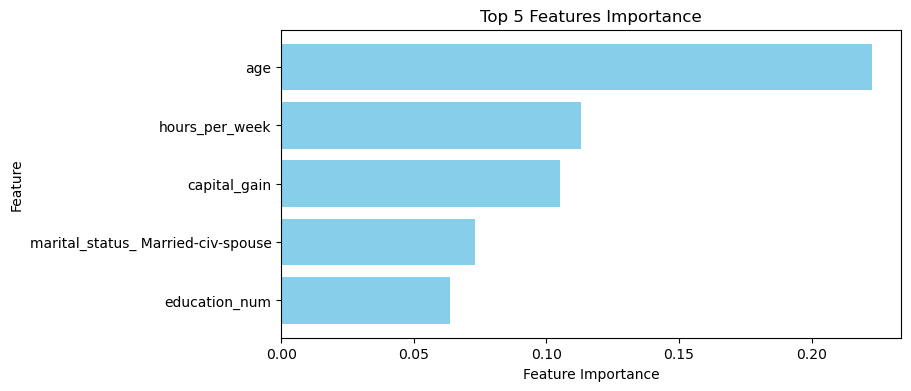

In [111]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get indices of top 5 features
top_indices = feature_importances.argsort()[-5:][::-1]

# Get top 5 feature names and their importances
top_features = X_train.columns[top_indices]
top_importances = feature_importances[top_indices]

# Plot top 5 features
plt.figure(figsize=(8, 4))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Features Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display top features at the top
plt.show()


In [112]:
from sklearn.metrics import classification_report

# Predicting for train data
train_predictions = rf_model.predict(X_train)

# Classification report for train data
print("Classification Report for Train Data:")
print(classification_report(y_train, train_predictions))


Classification Report for Train Data:
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.99     17265
        >50K       0.97      0.95      0.96      5527

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



In [21]:
# Using the fitted model to predict on the test data
y_pred_test = rf_model.predict(X_test)

# Calculating the predicted probabilities for each class
y_pred_proba_test = rf_model.predict_proba(X_test)

# Getting the predicted classes
predicted_classes = rf_model.classes_

In [22]:
from sklearn.metrics import classification_report

# Generate a classification report for the test data
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

       <=50K       0.89      0.92      0.90      7455
        >50K       0.70      0.63      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.85      9769



### Yes, there is indication of overfitting for the RandomForest model.Test score dropped significantly.

In [24]:
###3. AdaBoost Classifier - GridSearch:

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# AdaBoostClassifier
adaboost = AdaBoostClassifier()

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2]
}

#GridSearchCV
grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Getting the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)


Best Parameters: {'learning_rate': 1.2, 'n_estimators': 400}
Best Estimator: AdaBoostClassifier(learning_rate=1.2, n_estimators=400)


In [26]:
# Predicting on test data
y_pred_proba = best_estimator.predict_proba(X_test)
y_pred = best_estimator.predict(X_test)


In [27]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[7008  447]
 [ 807 1507]]
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92      7455
        >50K       0.77      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [28]:
from sklearn.metrics import roc_auc_score

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
print("AUC Score:", auc_score)


AUC Score: 0.9244122180504519


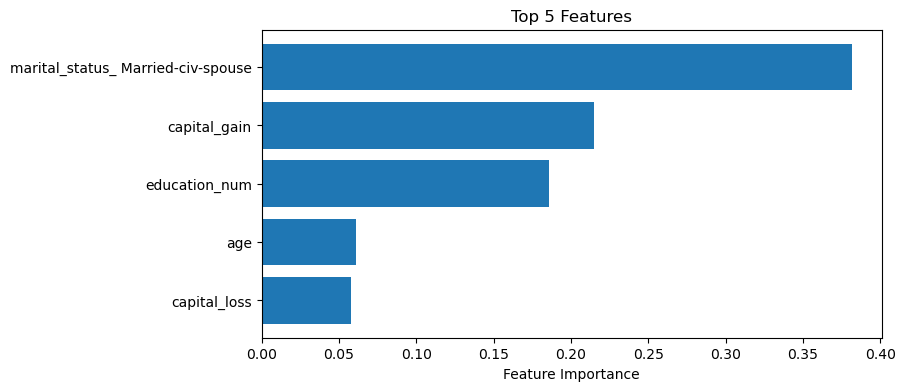

In [47]:
import matplotlib.pyplot as plt

#  feature importance scores
feature_importances = best_estimator.feature_importances_
cc
top5_features = X_train.columns[top5_indices]

# Plot top 5 features
plt.figure(figsize=(8, 4))
plt.barh(range(len(top5_features)), feature_importances[top5_indices], align='center')
plt.yticks(range(len(top5_features)), top5_features)
plt.xlabel('Feature Importance')
plt.title('Top 5 Features')
plt.gca().invert_yaxis()  # Invert y-axis to display top feature at the top
plt.show()


## Yes, there is some level of overfitting. Decrease in precision, recall and F-1 score for both classes.

#4. Gradient Boosting Classifier - GridSearch:

In [34]:
#a)from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd

# Defining the hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [1, 2]
}

# Initializing
gb_classifier = GradientBoostingClassifier()

# Initializing
grid_search = GridSearchCV(gb_classifier, param_grid, scoring='roc_auc', cv=5)

# Fitting GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Getting the best estimator
best_estimator = grid_search.best_estimator_



In [40]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score (ROC AUC):", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
Best Score (ROC AUC): 0.9201908189949538


In [35]:
#B. Predicting probabilities and classes for test data
y_pred_proba = best_estimator.predict_proba(X_test)
y_pred_class = best_estimator.predict(X_test)


In [41]:
#C. Calculating confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_class)
class_report = classification_report(y_test, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[7052  403]
 [ 900 1414]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92      7455
        >50K       0.78      0.61      0.68      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.87      0.86      9769



In [64]:
#D. Calculating AUC score
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
# Print AUC score
print("AUC Score:", auc_score)

AUC Score: 0.9190108382939527


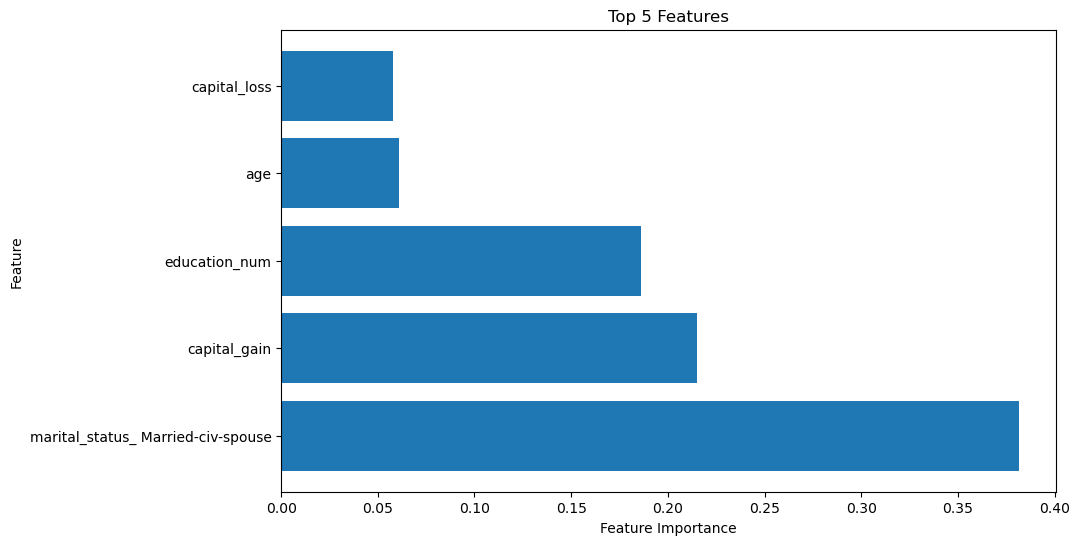

In [68]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = best_estimator.feature_importances_

# Get top 5 features
top_features = sorted(zip(feature_importances, X_train.columns), reverse=True)[:5]
top_feature_names = [feature[1] for feature in top_features]
top_feature_importances = [feature[0] for feature in top_features]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_importances)), top_feature_importances, align='center')
plt.yticks(range(len(top_feature_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Features')
plt.show()


In [85]:
#F. Predict for train data
y_train_pred = best_estimator.predict(X_train)
class_report_train = classification_report(y_train, y_train_pred)
# Print classification report for train data
print("Classification Report for Train Data:")
print(class_report_train)

Classification Report for Train Data:
              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92     17265
        >50K       0.79      0.62      0.69      5527

    accuracy                           0.87     22792
   macro avg       0.84      0.78      0.80     22792
weighted avg       0.86      0.87      0.86     22792



## Training score is slighly high. So,there is a sign of overfitting, but not severe. 

### 5. XGBoost - RandomizedSearchCV (I have atatched a separate file for this portion.....)